In [1]:
%pip install Unidecode
%pip install num2words
%pip install spacy
%pip install stanza

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports
Son las instalaciones necesarias para la preparacion de datos y la ejecucion del proyecto

Aqui importamos las librerias necesarias y se descarga el modelo en español de stanza.
Stanza es una colección de herramientas precisas y eficientes para el análisis lingüístico de muchos lenguajes humanos. A partir del texto sin formato, Stanza lo divide en oraciones y palabras, y luego puede reconocer partes del discurso y entidades, realizar análisis sintácticos y más.

In [4]:
import pandas as pd
import re
from unidecode import unidecode
import num2words
import spacy
from spacy.lang.es import stop_words as stop_words
import stanza
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


In [3]:
stanza.download("es")

2025-02-21 04:20:29 INFO: Downloaded file to C:\Users\juand\stanza_resources\resources.json
2025-02-21 04:20:29 INFO: Downloading default packages for language: es (Spanish) ...
2025-02-21 04:20:35 INFO: File exists: C:\Users\juand\stanza_resources\es\default.zip
2025-02-21 04:20:45 INFO: Finished downloading models and saved to C:\Users\juand\stanza_resources


# Carga de datos

In [5]:
df=pd.read_csv('fake_news_spanish.csv', encoding='utf-8', delimiter=';')
df

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


In [6]:
# verificamos si hay valores nulos
df.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [7]:
# corregimos los valores nulos y unimos las columnas 'Titulo' y 'Descripcion'
df['Titulo']=df['Titulo'].fillna('')
df['preparados']=df['Titulo']+df['Descripcion']
df


,ID,Label,Titulo,Descripcion,Fecha,preparados
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,'The Guardian' va con Sánchez: 'Europa necesit...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,Puigdemont: 'No sería ninguna tragedia una rep...
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,El Defensor del Pueblo reclama a la Comunidad ...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,El EQUO plantea ceder la presidencia de la Com...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,Alberto Garzón: 'Que los Borbones son unos lad...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,Vox exige entrar en el Gobierno de Castilla y ...


# Perfilamiento de datos

In [8]:
df['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [9]:
# chart de la distribución de las etiquetas
#df.groupby('Label').value_counts().plot(kind='bar', y = 'Label')

Observamos que hay una distribución poco equitativa de datos

# Preparación de los datos

Se uso la libreria de stanza para tokenizar y lemmatizar la columan 'preparados' del dataframe, debido a que este proceso se demora alrededor de una hora o más y es una cantidad excesiva de tiempo decidimos hacer una primera limpieza de los datos y exportarlo a un csv.

Definimos la funcion de normalizar texto para eliminar caracteres invalidos en unidecode

In [10]:
def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = unidecode(texto)

    return texto



In [11]:
def tokenizar(texto):
    # dividir el texto en palabras
    palabras = re.findall(r'\b\w+\b', texto)
    return palabras

In [12]:
stopwords_espanol = stop_words.STOP_WORDS
#Se usa Spacy porque tiene un "vocabulario" más amplio que NLTK
#Genera un mejor resultado debido a esto

def stopwords_espanol_remove(line):
    new_line=[]
    for word in line:
        if word not in stopwords_espanol:
            new_line.append(word)
    return new_line

In [13]:
def num_to_word(line):
    new_line=[]

    for word in line:
        if re.fullmatch(r'\d+',word):
            word=float(word)
            new_line.append(num2words.num2words(word, lang = 'es_CO'))
        else:
            new_line.append(word)
    return new_line



In [14]:
def preprocesamiento():
    df['preparados'] = df['preparados'].apply(normalizar)
    df['preparados'] = df['preparados'].apply(tokenizar)
    df['preparados'] = df['preparados'].apply(stopwords_espanol_remove)
    df['preparados'] = df['preparados'].apply(num_to_word)
    df['tamanio']=df['preparados'].apply(len)
    df['preparados'] = df['preparados'].apply(lambda x: ' '.join(x))
    return df

# Alternativa + leming

In [15]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2025-02-21 10:56:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-21 10:56:47 INFO: Downloaded file to C:\Users\juand\stanza_resources\resources.json
2025-02-21 10:56:48 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-02-21 10:56:48 INFO: Using device: cpu
2025-02-21 10:56:48 INFO: Loading: tokenize
2025-02-21 10:56:53 INFO: Loading: mwt
2025-02-21 10:56:53 INFO: Loading: pos
2025-02-21 10:56:58 INFO: Loading: lemma
2025-02-21 10:57:01 INFO: Done loading processors!


In [16]:
nlp = spacy.load('es_core_news_sm')

In [17]:
def lemmatizer(text):  
  doc = nlp(text)
  return [word.lemma_ for word in doc]

In [36]:

try:
    df=pd.read_csv('fake_news_spanish_preprocesado.csv', encoding='utf-8')
    df['preparados']=df['preparados'].apply(eval)
except:
    preprocesamiento()
    df['preparados']=df['preparados'].apply(lemmatizer)
    df['preparados'] = df['preparados'].apply(stopwords_espanol_remove)
    df['preparados'] = df['preparados'].apply(num_to_word)  
    df.to_csv('fake_news_spanish_preprocesado.csv', index=False)
df['preparados']

0        [the, guardian, sanchez, europa, necesitar, ap...
1        [revelan, gobierno, negocio, liberacion, mirel...
2        [joan, fuster, estatuto, valenciano, cumplir, ...
3        [iglesias, alentar, yolanda, diaz, erc, eh, bi...
4        [puigdemont, tragedia, repeticion, elecciones,...
                               ...                        
57058    [defensor, pueblo, reclamar, comunidad, madrid...
57059    [equo, plantear, ceder, presidencia, comunidad...
57060    [alberto, garzon, borbones, ladron, historicam...
57061    [vox, exigir, entrar, gobierno, castilla, leon...
57062    [trescientos, persona, protestar, visita, rey,...
Name: preparados, Length: 57063, dtype: object

# Algoritmo 1: Random Forest

La idea de este algoritmo es instanciar varios 'decision trees' y lograr usar todas sus predicciones para tomar una decisión. En primer lugar, usa (de manera aleatoria) distintos subconjuntos de las características de los datos de entrenamiento para generar los diferentes árboles y buscar relaciones. Al crear varios árboles de manera adecuada se evita el overfitting, bias en los datos y otros problemas para las predicciones.

Juan Diego Sánchez - 202214625

In [41]:
# se crea una copia para el uso de Random Forest
df_rand_forest=df.copy(True)

In [ ]:
def join_words(line):
    #print(type(line))
    return ' '.join(line)

In [43]:
df_rand_forest['preparados'].apply(join_words)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

0        the guardian sanchez europa necesitar apuesta ...
1        revelan gobierno negocio liberacion mireles ca...
2        joan fuster estatuto valenciano cumplir cuaren...
3        iglesias alentar yolanda diaz erc eh bildu neg...
4        puigdemont tragedia repeticion elecciones entr...
                               ...                        
57058    defensor pueblo reclamar comunidad madrid dato...
57059    equo plantear ceder presidencia comunidad madr...
57060    alberto garzon borbones ladron historicamente ...
57061    vox exigir entrar gobierno castilla leon cara ...
57062    trescientos persona protestar visita rey barce...
Name: preparados, Length: 57063, dtype: object

In [44]:
# se unen las palabras en una sola cadena
df_rand_forest['textos'] = df_rand_forest['preparados'].apply(lambda x: ' '.join(map(str, x)))
df_rand_forest['textos']

0        the guardian sanchez europa necesitar apuesta ...
1        revelan gobierno negocio liberacion mireles ca...
2        joan fuster estatuto valenciano cumplir cuaren...
3        iglesias alentar yolanda diaz erc eh bildu neg...
4        puigdemont tragedia repeticion elecciones entr...
                               ...                        
57058    defensor pueblo reclamar comunidad madrid dato...
57059    equo plantear ceder presidencia comunidad madr...
57060    alberto garzon borbones ladron historicamente ...
57061    vox exigir entrar gobierno castilla leon cara ...
57062    trescientos persona protestar visita rey barce...
Name: textos, Length: 57063, dtype: object

In [45]:
# se crean los datos para el modelo (x_data = caracteristicas y y_data=prediccion)
X_data, y_data = df_rand_forest['textos'],df_rand_forest['Label']
y_data

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 57063, dtype: int64

In [46]:
train_text, test_text, train_labels, test_labels = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2)
print(f'Training examples: {len(train_text)}, testing examples {len(test_text)}')

Training examples: 45650, testing examples 11413


In [47]:
train_labels.value_counts()

Label
1    26526
0    19124
Name: count, dtype: int64

In [48]:
test_labels.value_counts()

Label
1    6632
0    4781
Name: count, dtype: int64

In [49]:
train_text

33360    bloque investidura vigilar acercamiento cristi...
19270    parlamento galicia reconocer dictadura franqui...
44802    eurodiputado jordi sole erc querellar espionaj...
11040    congreso aprobar minima reforma laboral mayori...
32259    informe camara cuentas andalucia instar gobier...
                               ...                        
28564    espinosa clara campoamors adelantar congreso p...
44828    gobierno visita rey emerito perder oportunidad...
19500    sanchez distanciar iglesias descartar suspende...
6509     diego canamero afrontar viernes investidura pr...
3925     unidas denunciar fiscalia bulo relacionado cor...
Name: textos, Length: 45650, dtype: object

In [50]:
vectoryzer= CountVectorizer(binary=True)
train_x= vectoryzer.fit_transform(train_text) 
test_x= vectoryzer.transform(test_text)

In [ ]:
forest=RandomForestClassifier()
forest.fit(train_x, train_labels)

In [ ]:
forest.score(test_x, test_labels)

0.8911767282922982

In [ ]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Probemos ahora este modelo sobre test.
y_pred_train = forest.predict(train_x)
y_pred_test = forest.predict(test_x)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(train_labels, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(test_labels, y_pred_test))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.89


In [ ]:
# ¿Overfitting?

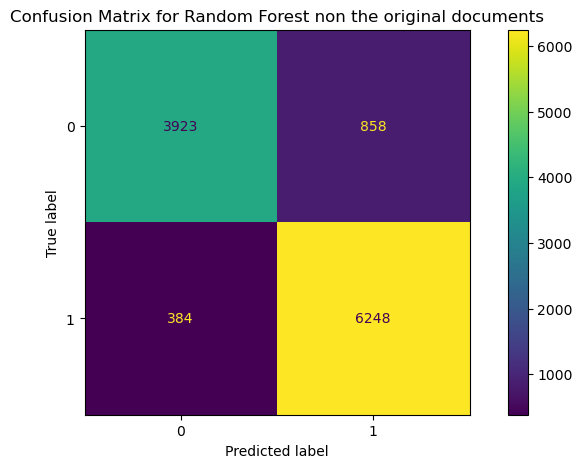

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test, ax=ax)

_ = ax.set_title(
    f"Confusion Matrix for Random Forest non the original documents"
)

In [ ]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      4781
           1       0.88      0.94      0.91      6632

    accuracy                           0.89     11413
   macro avg       0.90      0.88      0.89     11413
weighted avg       0.89      0.89      0.89     11413



In [ ]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [ ]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid= {'criterion':['gini', 'entropy','log_loss'], 'max_features':['auto', 'sqrt', 'log2']}

In [ ]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(forest, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(train_x, train_labels)

## Segunda iteración

In [ ]:
# la idea es procesar de forma distinta las noticias aquí